In [2]:
!pip -q install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
from ultralytics import YOLO

# -----------------------------
# Load a YOLO model (accurate + lightweight)
# Options: yolov8n.pt (fast), yolov8s.pt (better), yolov8m.pt (even better)
# -----------------------------
model = YOLO("yolov8s.pt")  # change to yolov8m.pt if you want higher accuracy

PERSON_CLASS_ID = 0

def detect_people_bgr(
    frame_bgr,
    conf=0.35,
    iou=0.50,
    draw=True,
    show_count=True
):
    """
    Detect people in a BGR frame using YOLO.
    Returns: (annotated_frame, count, boxes_xyxy)
    """
    # YOLO expects RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    results = model.predict(
        source=frame_rgb,
        conf=conf,
        iou=iou,
        classes=[PERSON_CLASS_ID],   # only "person"
        verbose=False
    )

    r = results[0]
    boxes = r.boxes

    count = 0
    boxes_xyxy = []

    if boxes is not None and len(boxes) > 0:
        for b in boxes:
            x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().astype(int)
            score = float(b.conf[0].cpu().numpy())
            boxes_xyxy.append((x1, y1, x2, y2, score))
        count = len(boxes_xyxy)

    annotated = frame_bgr.copy()

    if draw:
        for i, (x1, y1, x2, y2, score) in enumerate(boxes_xyxy, start=1):
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                annotated,
                f"person {i} ({score:.2f})",
                (x1, max(20, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 255),
                2
            )

    if show_count:
        cv2.putText(
            annotated,
            f"Total Persons: {count}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (255, 0, 0),
            2
        )

    return annotated, count, boxes_xyxy


def run_on_image(image_path, output_path=None, conf=0.35, iou=0.50):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    annotated, count, _ = detect_people_bgr(img, conf=conf, iou=iou)

    # For Colab display
    try:
        from google.colab.patches import cv2_imshow
        print("Detected persons:", count)
        cv2_imshow(annotated)
    except Exception:
        print("Detected persons:", count)
        cv2.imshow("People Detection", annotated)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    if output_path:
        cv2.imwrite(output_path, annotated)
        print("Saved:", output_path)


def run_on_video(video_path, output_path=None, conf=0.35, iou=0.50, display_every=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Video not found/cannot open: {video_path}")

    # Setup writer if output requested
    writer = None
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    i = 0
    last_count = None

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        annotated, count, _ = detect_people_bgr(frame, conf=conf, iou=iou)
        last_count = count

        if writer:
            writer.write(annotated)

        # Colab can't do smooth realtime playback; show occasionally
        if i % display_every == 0:
            try:
                from google.colab.patches import cv2_imshow
                print("Frame:", i, "Detected persons:", count)
                cv2_imshow(annotated)
            except Exception:
                cv2.imshow("People Detection", annotated)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        i += 1

    cap.release()
    if writer:
        writer.release()
        print("Saved:", output_path)

    try:
        cv2.destroyAllWindows()
    except:
        pass

    if last_count is not None:
        print("Last frame persons:", last_count)


def run_on_camera(camera_index=0, output_path=None, conf=0.35, iou=0.50):
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        raise RuntimeError("Cannot open camera. Note: Colab typically cannot access webcam.")

    writer = None
    fps = 25
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        annotated, count, _ = detect_people_bgr(frame, conf=conf, iou=iou)
        cv2.imshow("People Detection", annotated)

        if writer:
            writer.write(annotated)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    if writer:
        writer.release()
    cv2.destroyAllWindows()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Detected persons: 3


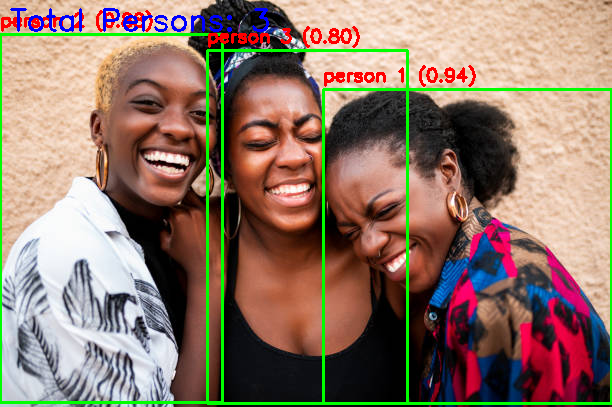

Saved: /content/out.jpg


In [6]:
image_path = "/content/image.jpg"
run_on_image(image_path, output_path="/content/out.jpg", conf=0.25, iou=0.50)

Detected persons: 3


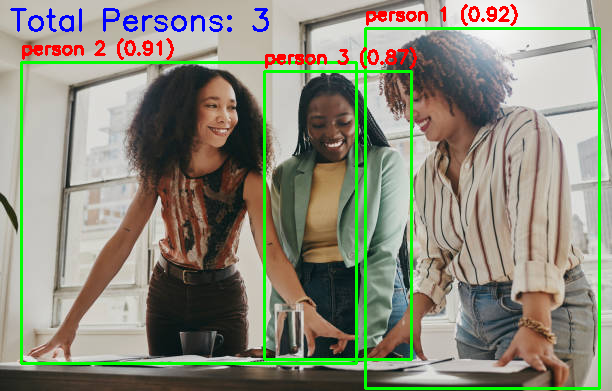

Saved: /content/out.jpg


In [8]:
image_path = "/content/Image 3.jpg"
run_on_image(image_path, output_path="/content/out.jpg", conf=0.25, iou=0.50)